# HSV Example

This example demonstrates the use of `hsv` operation which manipulates the hue, saturation and value (brightness) aspects of the image.


## Introduction
### HSV Color Space
HSV represents colors by separating hue, saturation and brightness. In this color space, the hue is represented as an angle on the color circle. Saturation goes from 0 (greyscale) to 100% (fully saturated colors) and value goes from 0 (black) to 1 (full brightness). For details see:
[Wikipedia](https://en.wikipedia.org/wiki/HSL_and_HSV).

### A Note on Implementation
For performance reasons, DALI doesn't use the exact definition of HSV and approximates the operations in HSV space by linear (matrix) operations on RGB colors. This greatly improves performance at the cost of modest loss of fidelity.

## Usage Example

Let's start by importing the necessary modules and loading an image.

In [1]:
import math
from pathlib import Path

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import nvidia.dali.experimental.dynamic as ndd
import nvidia.dali.types as types

image_dir = Path("../data/images")
image_path = next(image_dir.glob("**/*.jpg"))
image = ndd.imread(image_path)

The function below is used to display the results of HSV manipulation. It takes a list of tensors and displays them side by side. For GPU tensors, we call `.cpu()` to get a CPU-accessible copy of the data for visualization.

In [2]:
def display(outputs: list[ndd.Tensor], columns: int = 2, captions: list[str] | None = None):
    rows = int(math.ceil(len(outputs) / columns))
    fig = plt.figure(figsize=(16, 6 * rows))
    gs = gridspec.GridSpec(rows, columns)
    for i, out in enumerate(outputs):
        plt.subplot(gs[i])
        plt.axis("off")
        if captions is not None:
            plt.title(captions[i])
        plt.imshow(out.cpu())

Let's apply HSV manipulation on the CPU: rotating hue by 120 degrees and reducing brightness.

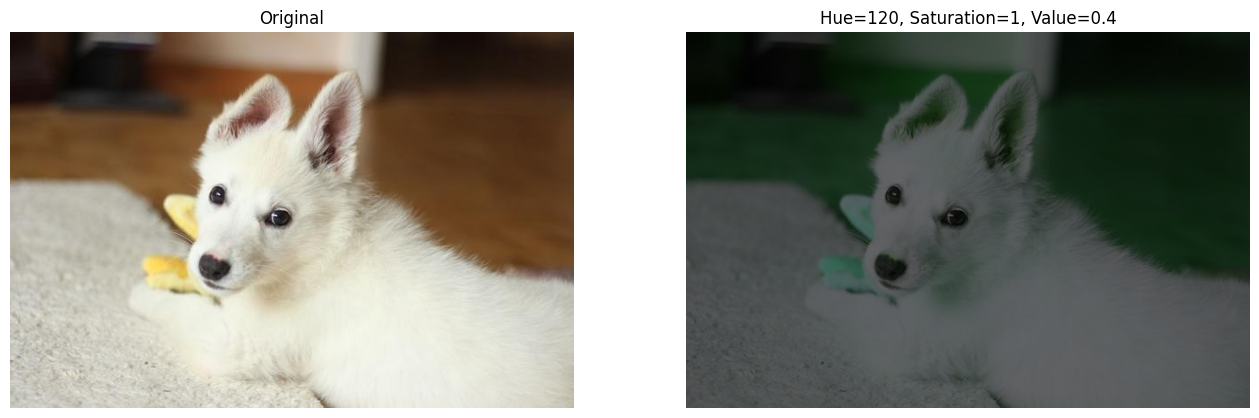

In [3]:
converted_cpu = ndd.hsv(image, hue=120, saturation=1, value=0.4)
display([image, converted_cpu], captions=["Original", "Hue=120, Saturation=1, Value=0.4"])

Now let's run on the GPU with different parameters: hue rotation and increased saturation.

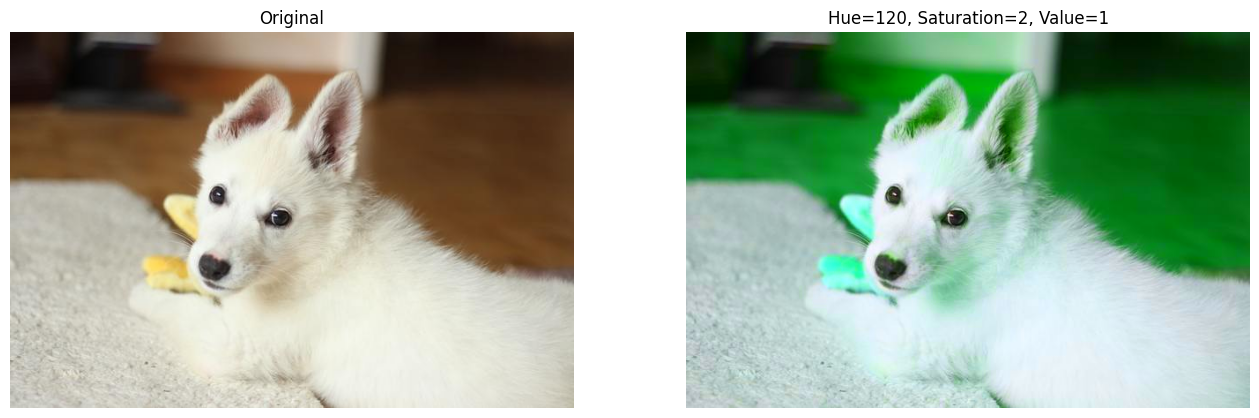

In [4]:
image_gpu = ndd.as_tensor(image, device="gpu")
converted_gpu = ndd.hsv(image_gpu, hue=120, saturation=2, value=1)
display([image_gpu, converted_gpu], captions=["Original", "Hue=120, Saturation=2, Value=1"])

# Using HSV to Implement RandomGrayscale

As a more interesting example, we can implement something similar to PyTorch's `RandomGrayscale` transformation. For an RGB input, we either convert it to a grayscale image (that still has 3 channels but with equal values) or pass it through unchanged.

To achieve the grayscale conversion, we desaturate the input (set `saturation` to 0). If we set `saturation` to 1, the image keeps its colors.

We use `ndd.random.coin_flip` to randomly decide whether to convert. Since `coin_flip` returns integers and `hsv` expects floats, we also need to convert the values using `ndd.cast`.

In [5]:
def random_grayscale(image: ndd.Tensor, probability: float, rng: ndd.random.RNG) -> ndd.Tensor:
    saturate = ndd.random.coin_flip(probability=1 - probability, rng=rng)
    saturate = ndd.cast(saturate, dtype=types.FLOAT)
    return ndd.hsv(image, saturation=saturate)

In [6]:
rng = ndd.random.RNG(seed=422)
converted_random = random_grayscale(image_gpu, probability=0.6, rng=rng)

With a 60% probability of grayscale conversion, running multiple times will randomly show the image as either grayscale or color.

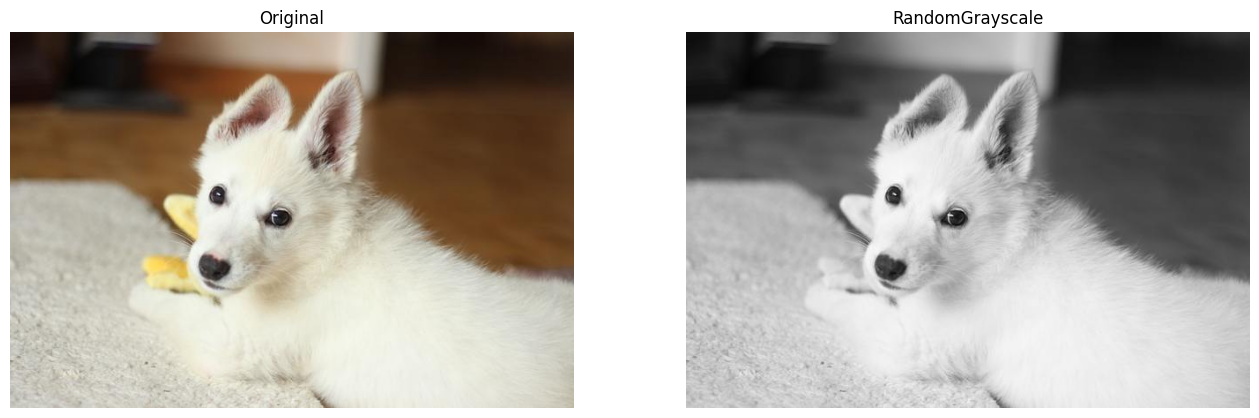

In [7]:
display([image_gpu, converted_random], captions=["Original", "RandomGrayscale"])